In [1]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
import os
import numpy as np
from hp import *
from utils import *
from keras import initializers

%load_ext autoreload
%autoreload 2

2023-05-15 11:04:43.221866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:04:43.254624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:04:43.255205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 11:04:43.789193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-15 11:04:44.463469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [3]:
def fit_func_prepare(params, data_path):
    data = load_data(data_path)
    train_data = (data["x_train"], data["y_train"])
    val_data = (data["x_test"], data["y_test"])

    model_type = params["model_type"]
    model_kwargs = get_model_kwargs(model_type)
    params = {**params, **model_kwargs}

    x_args = params.pop("net_x_arch_trunk_args")
    params["net_x_arch_trunk"] = relu_network(
        [x_args["x_units"]] * x_args["x_layers"], dropout=x_args["dropout"]
    )
    y_args = params.pop("net_y_size_trunk_args")
    params["net_y_size_trunk"] = nonneg_tanh_network(y_args["y_base_units"],
        dropout=y_args["dropout"], **y_args["kwargs"]
    )

    seed = params.pop("seed")
    set_seeds(seed)
    return train_data,val_data, params

def fit_func(params, data_path, fast):
    train_data, val_data, params = fit_func_prepare(params, data_path)
    hist, neat_model = fit(
        epochs=20 if fast else 10_000,
        train_data=train_data,
        val_data=val_data,
        **params,
    )
    return neat_model, hist

data_path = "energy"
hp_param = {
            "seed": 1,
            "net_x_arch_trunk_args": {
                "x_units": 20,
                "x_layers": 1,
                "dropout": 0,
            },
            "net_y_size_trunk_args": {
                "y_base_units": [100,100,20],
                "dropout": 0.0,
                "kwargs": dict(kernel_initializer=initializers.RandomUniform(minval=0., maxval=1.))
                # "kwargs": dict(kernel_initializer=constraint_xavier_init)
            },
            "optimizer": Adam(learning_rate=1e-3),
            "base_distribution": tfd.Normal(loc=0, scale=1),
            "model_type": ModelType.LS,
        }

# Train "large" model with RandomUniform(0,1) initialisation

In [3]:
neat_model, hist = fit_func(hp_param, data_path, fast=True)

/home/daniel/miniconda3/envs/py10/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/20


22/22 [==============================] - 2s 32ms/step - logLik: 635.0753 - val_logLik: 262.3986
Epoch 2/20
22/22 [==============================] - 0s 6ms/step - logLik: 610.2656 - val_logLik: 256.2336
Epoch 3/20
22/22 [==============================] - 0s 7ms/step - logLik: 602.5109 - val_logLik: 254.0919
Epoch 4/20
22/22 [==============================] - 0s 6ms/step - logLik: 600.1098 - val_logLik: 253.2114
Epoch 5/20
22/22 [==============================] - 0s 7ms/step - logLik: 599.2148 - val_logLik: 252.7607
Epoch 6/20
22/22 [==============================] - 0s 6ms/step - logLik: 598.7342 - val_logLik: 252.4732
Epoch 7/20
22/22 [==============================] - 0s 7ms/step - logLik: 598.4319 - val_logLik: 252.3018
Epoch 8/20
22/22 [==============================] - 0s 6ms/step - logLik: 598.1928 - val_logLik: 252.1517
Epoch 9/20
22/22 [==============================] - 0s 6ms/step - logLik: 598.0151 - val_logLik: 252.0637
Epoch 10/20
22/22 [==============================] - 0s 

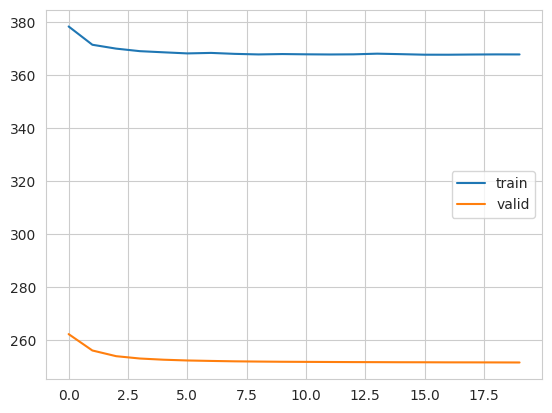

In [4]:
plt.plot(hist.history['logLik'], label='train')
plt.plot(hist.history['val_logLik'], label='valid')
plt.legend()

### plot transformation function

4/4 [==============================] - 0s 5ms/step


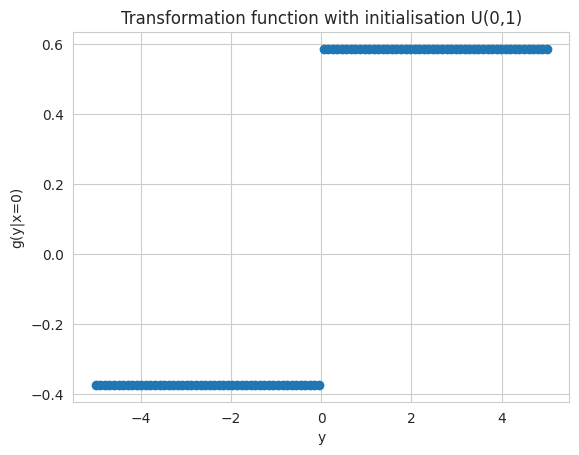

In [5]:
yy = np.linspace(-5,5,100)
xx = np.zeros((yy.shape[0], 8))
z = neat_model.predict((xx,yy))
plt.title("Transformation function with initialisation U(0,1)")
plt.xlabel("y")
plt.ylabel("g(y|x=0)")
plt.scatter(yy, z)
plt.savefig("images/initialisation_u(01).pdf")

# Train "large" model with adapted Xavier initialisation

In [6]:
data_path = "energy"
def constraint_xavier_p_init(shape, dtype=None):
    fan_in = shape[0]
    fan_out = shape[1]
    # limit = np.sqrt(6. / (fan_in+fan_out))
    limit = np.sqrt(9. / (np.max([fan_in, fan_out])**2))
    return tf.random.uniform(shape, minval=0, maxval=limit, dtype=dtype)
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=constraint_xavier_p_init)
neat_model, hist = fit_func(hp_param, data_path, fast=False)

Epoch 1/10000
22/22 [==============================] - 2s 18ms/step - logLik: 62.0383 - val_logLik: 16.1226
Epoch 2/10000
22/22 [==============================] - 0s 6ms/step - logLik: 30.7293 - val_logLik: 9.5014
Epoch 3/10000
22/22 [==============================] - 0s 7ms/step - logLik: 18.2467 - val_logLik: 5.5253
Epoch 4/10000
22/22 [==============================] - 0s 6ms/step - logLik: 10.9881 - val_logLik: 3.2062
Epoch 5/10000
22/22 [==============================] - 0s 6ms/step - logLik: 5.9190 - val_logLik: 1.8124
Epoch 6/10000
22/22 [==============================] - 0s 7ms/step - logLik: 2.4463 - val_logLik: 0.5032
Epoch 7/10000
22/22 [==============================] - 0s 6ms/step - logLik: 1.2294 - val_logLik: 1.0831
Epoch 8/10000
22/22 [==============================] - 0s 8ms/step - logLik: -0.5617 - val_logLik: -0.0446
Epoch 9/10000
22/22 [==============================] - 0s 6ms/step - logLik: -2.2473 - val_logLik: -0.7224
Epoch 10/10000
22/22 [=======================

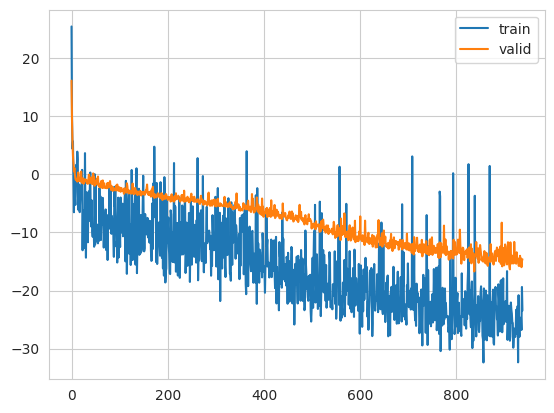

In [7]:
plt.plot(hist.history['logLik'], label='train')
plt.plot(hist.history['val_logLik'], label='valid')
plt.legend()

## plot transformation function
This weight initialization does function and our NN converged

4/4 [==============================] - 0s 2ms/step


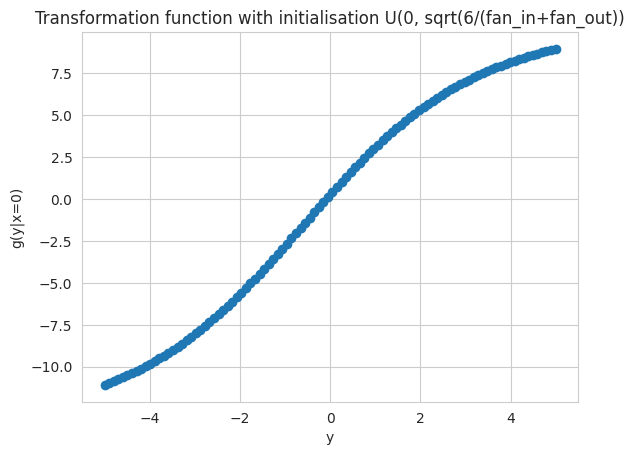

In [8]:
yy = np.linspace(-5,5,100)
xx = np.zeros((yy.shape[0], 8))
z = neat_model.predict((xx,yy))
plt.title("Transformation function with initialisation U(0, sqrt(6/(fan_in+fan_out))")
plt.xlabel("y")
plt.ylabel("g(y|x=0)")
plt.scatter(yy, z)
plt.savefig("images/initialisation_xavier_uniform+.pdf")

 we also see that the data is almost transformed into a Normal distribution

22/22 [==============================] - 0s 2ms/step


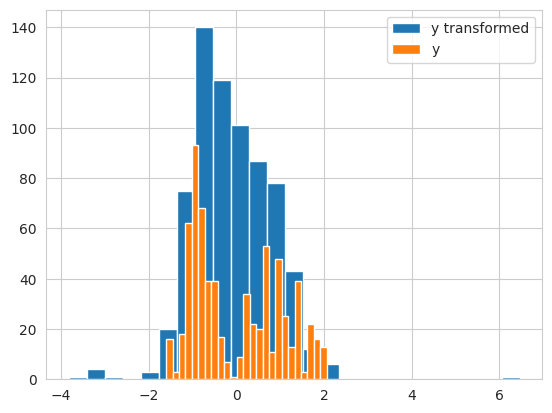

In [9]:
yy = load_data(data_path)['y_train']
xx = load_data(data_path)['x_train']
z = neat_model.predict((xx,yy))
plt.hist(z, bins=25, label="y transformed")
plt.hist(load_data(data_path)['y_train'], bins=25, label="y")
plt.legend()

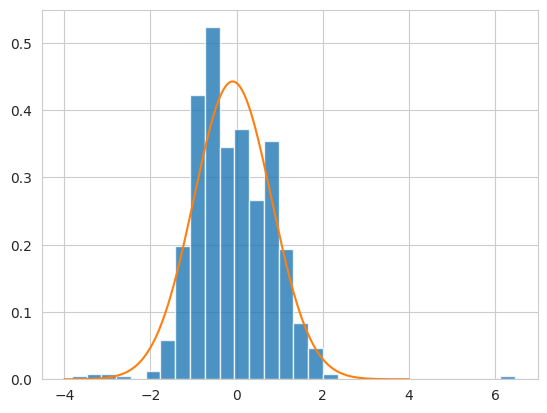

In [10]:
from scipy import stats
num_bins=30
plt.hist(z, bins=num_bins, alpha=0.8, density=True)

yy = np.linspace(-4, 4, 1000)
bin_width = (z.max() - z.min()) / num_bins
plt.plot(yy, stats.norm(z.mean(), z.std()).pdf(yy))

# Train realy large model (y_net = 100 neurons with 10 Layers) and with adapted Xavier initialisation

In [4]:
def constraint_xavier_p_init(shape, dtype=None):
    fan_in = shape[0]
    fan_out = shape[1]
    # limit = np.sqrt(6. / (fan_in+fan_out))
    limit = np.sqrt(9. / (np.max([fan_in, fan_out])**2))
    return tf.random.uniform(shape, minval=0, maxval=limit, dtype=dtype)

In [5]:
data_path = "energy"
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=constraint_xavier_p_init)
hp_param['net_y_size_trunk_args']['y_base_units'] = [100]*10
neat_model, hist = fit_func(hp_param, data_path, fast=False)

Epoch 1/10000


22/22 [==============================] - 1s 12ms/step - logLik: 77.1432 - val_logLik: 16.5052
Epoch 2/10000
22/22 [==============================] - 0s 3ms/step - logLik: 30.3669 - val_logLik: 11.0366
Epoch 3/10000
22/22 [==============================] - 0s 3ms/step - logLik: 19.1663 - val_logLik: 8.9855
Epoch 4/10000
22/22 [==============================] - 0s 3ms/step - logLik: 12.2542 - val_logLik: 7.5640
Epoch 5/10000
22/22 [==============================] - 0s 3ms/step - logLik: 10.9249 - val_logLik: 11.4784
Epoch 6/10000
22/22 [==============================] - 0s 3ms/step - logLik: 10.5547 - val_logLik: 5.3602
Epoch 7/10000
22/22 [==============================] - 0s 3ms/step - logLik: 7.5407 - val_logLik: 8.0299
Epoch 8/10000
22/22 [==============================] - 0s 3ms/step - logLik: 6.1067 - val_logLik: 3.2476
Epoch 9/10000
22/22 [==============================] - 0s 3ms/step - logLik: 4.8232 - val_logLik: 3.4925
Epoch 10/10000
22/22 [==============================] - 0s 

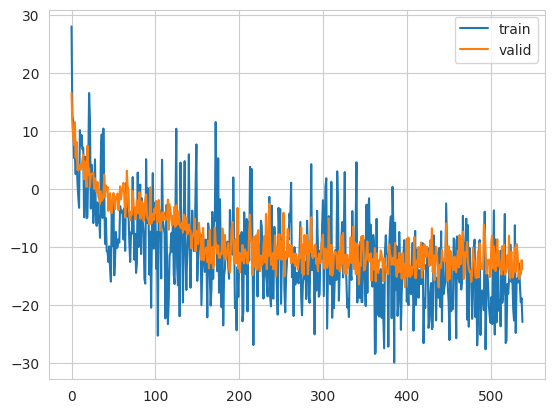

In [6]:
plt.plot(hist.history['logLik'], label='train')
plt.plot(hist.history['val_logLik'], label='valid')
plt.legend()

## plot transformation function
With this setting it still breaks

4/4 [==============================] - 0s 1ms/step


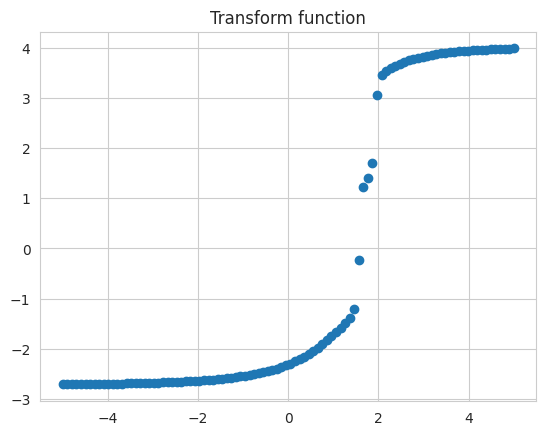

In [7]:
yy = np.linspace(-5,5,100)
xx = np.zeros((yy.shape[0], 8))
z = neat_model.predict((xx,yy))
plt.title("Transform function")
plt.scatter(yy, z)

22/22 [==============================] - 0s 859us/step


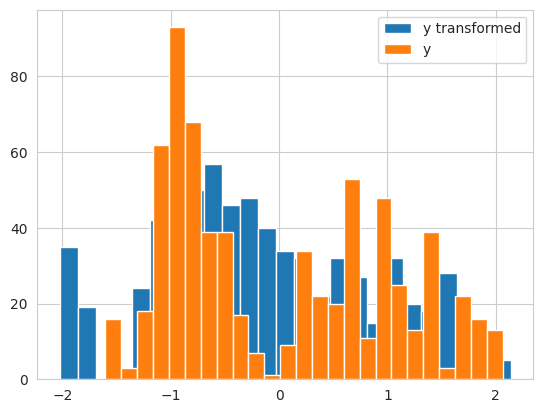

In [8]:
yy = load_data(data_path)['y_train']
xx = load_data(data_path)['x_train']
z = neat_model.predict((xx,yy))
plt.hist(z, bins=25, label="y transformed")
plt.hist(load_data(data_path)['y_train'], bins=25, label="y")
plt.legend()

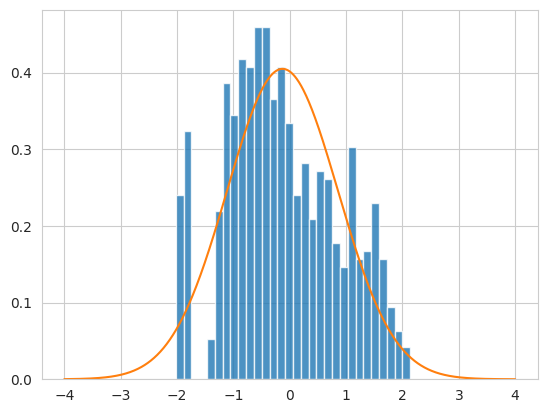

In [9]:
from scipy import stats
num_bins=30
plt.hist(z, bins=num_bins, alpha=0.8, density=True)

yy = np.linspace(-4, 4, 1000)
bin_width = (z.max() - z.min()) / num_bins
plt.plot(yy, stats.norm(z.mean(), z.std()).pdf(yy))

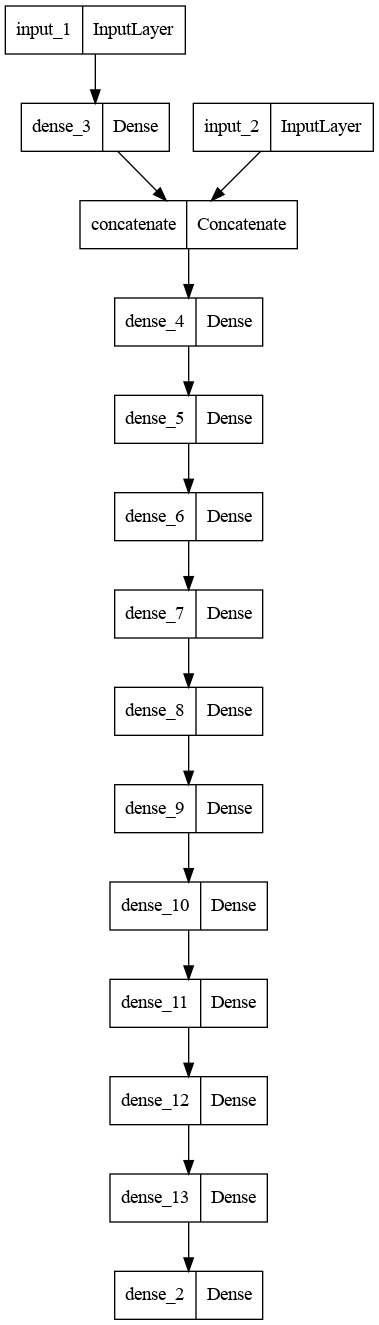

In [10]:
tf.keras.utils.plot_model(neat_model)

# Analyse initialisation
https://www.deeplearning.ai/ai-notes/initialization/index.html#III
$ Var(a^{l}) = n^{l-1}Var(W^l)Var(a^{l-1}) + n^{l-1}\mathbb{E}[W^l]²Var(a^{l-1})$
Var(a^l) == Var(a^{l-1}) ==>
$\frac{1}{n^{l-1}} = Var(W^l) + \mathbb{E}[W^l]²$
Using Uniform with U(0,b)
$\frac{1}{n^{l-1}} = \frac{1}{12}b² + {\frac{1}{2}b}²$
==>
$b=\sqrt{\frac{3}{n^{l-1}}}$


## Uniform(0,1) initialisation

/home/daniel/miniconda3/envs/py10/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


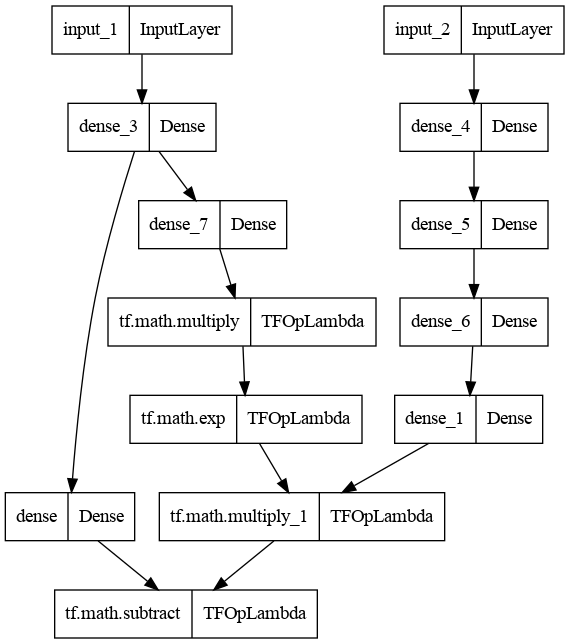

In [11]:
# recreate model
tf.keras.backend.clear_session()
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=initializers.RandomUniform(minval=0., maxval=1.))
hp_param['net_y_size_trunk_args']['y_base_units'] = [100,100,20]
train_data, val_data, params = fit_func_prepare(hp_param, data_path)
neat_model = get_neat_model(dim_features=train_data[0].shape[1], **params)
tf.keras.utils.plot_model(neat_model)

### plot activation distribution

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_4/Tanh:0', description="created by layer 'dense_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_5/Tanh:0', description="created by layer 'dense_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='dense_6/Tanh:0', description="created by layer 'dense_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")
313/313 [==============================] - 1s 2ms/step


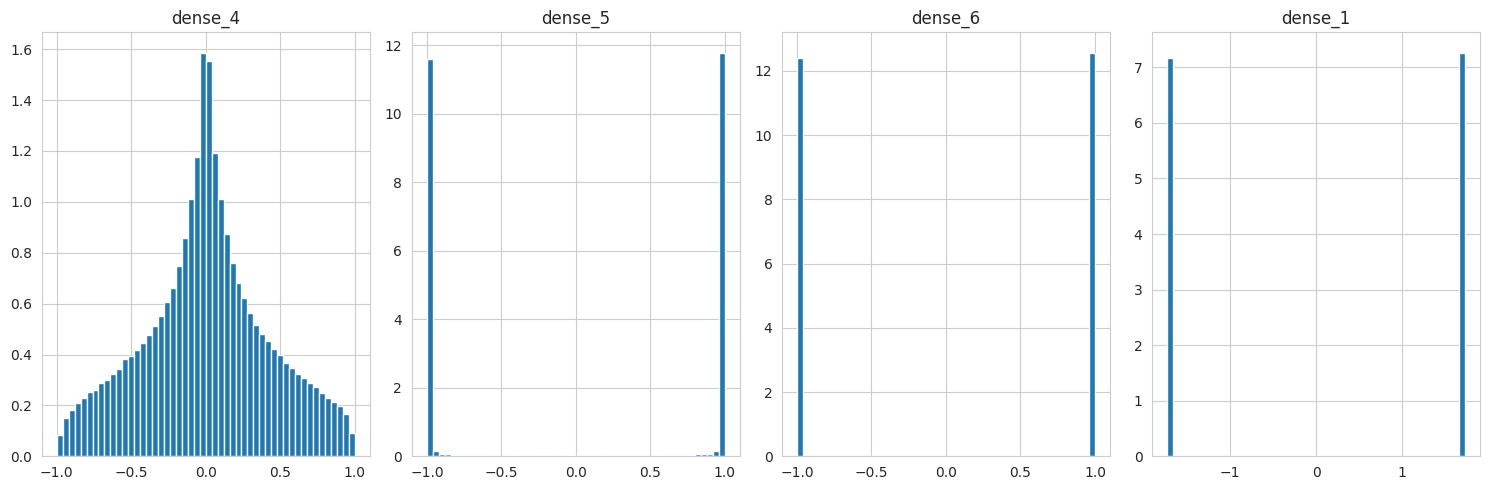

In [12]:
# Generate some random input data
x = np.random.randn(10000, 1)

# Get the activations for the input data
layer_outputs = []
layers = []
layer_names = []
for l in neat_model.layers:
    if l.name in ['dense_4', 'dense_5', 'dense_6', 'dense_1']:
        print(l.output)
        layer_outputs.append(l.output)
        layer_names.append(l.name)
        layers.append(l)
activation_model = tf.keras.models.Model(inputs=neat_model.inputs[1], outputs=layer_outputs)
activations = activation_model.predict(x)

# Plot the activations

# Determine the number of columns for the subplot
num_columns = len(layers)
# Create the subplot
fig, axs = plt.subplots(1, num_columns, figsize=(15, 5))
for ax, layer_name, activation in zip(axs, layer_names, activations):
    ax.set_title(layer_name)
    ax.hist(activation.flatten(), bins=50, density=True)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### plot weight distribution

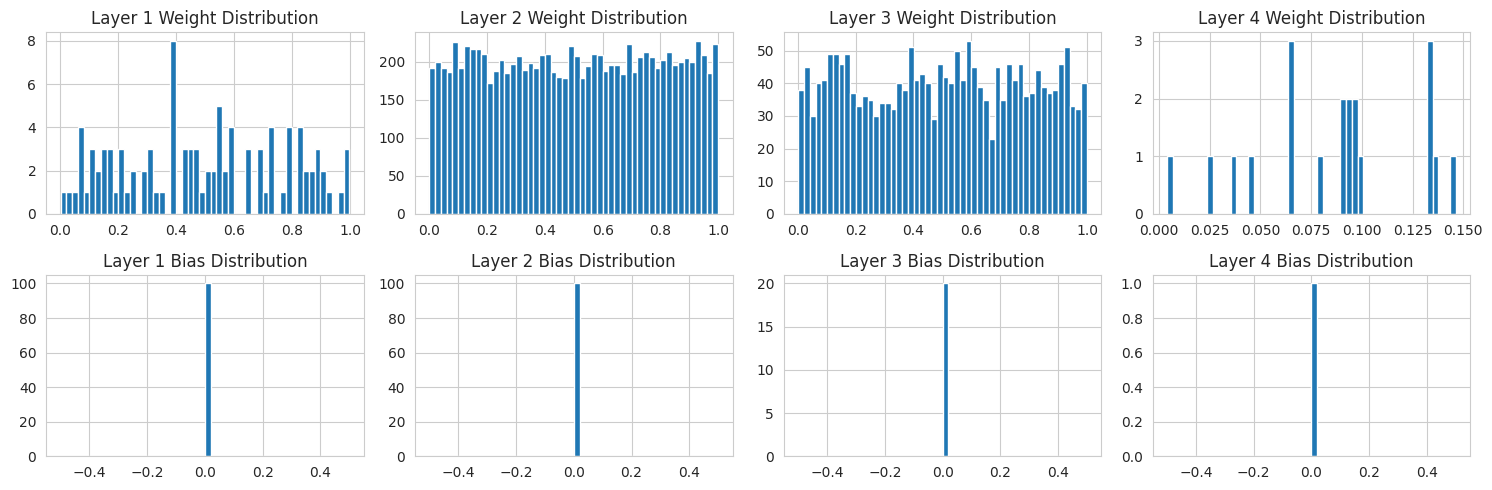

In [13]:
# Get the weights for each layer
layer_weights = [layer.get_weights() for layer in layers]

# Create the subplot
fig, axs = plt.subplots(2, num_columns, figsize=(15, 5))

# Plot the weight distribution for each layer
for i, weights in enumerate(layer_weights):
    axs[0,i].set_title(f"Layer {i+1} Weight Distribution")
    flattened_weights = weights[0].flatten()
    axs[0,i].hist(flattened_weights, bins=50)
    axs[1,i].set_title(f"Layer {i+1} Bias Distribution")
    flattened_weights = weights[1].flatten()
    axs[1,i].hist(flattened_weights, bins=50)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



## abs Xavier initialisation

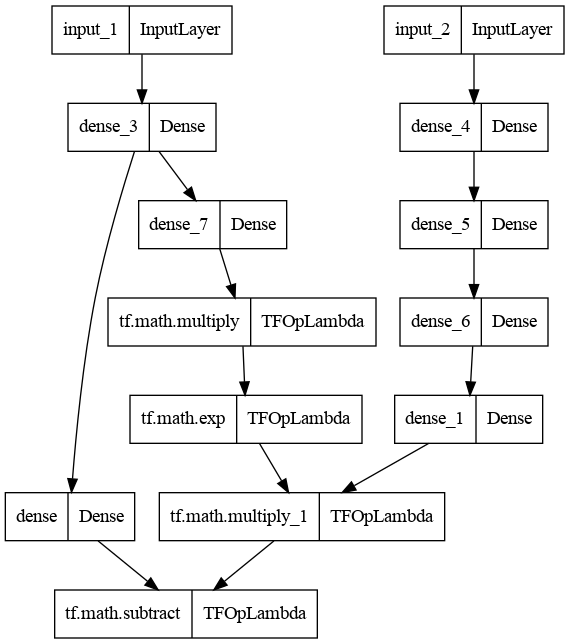

In [14]:
# recreate model
tf.keras.backend.clear_session()
def abs_xavier_init(shape, dtype=None):
    fan_in = shape[0]
    fan_out = shape[1]
    limit = np.sqrt(6. / (fan_in + fan_out))
    return tf.random.uniform(shape, minval=0., maxval=limit, dtype=dtype)
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=abs_xavier_init)
hp_param['net_y_size_trunk_args']['y_base_units'] = [100,100,20]
train_data, val_data, params = fit_func_prepare(hp_param, data_path)
neat_model = get_neat_model(dim_features=train_data[0].shape[1], **params)
tf.keras.utils.plot_model(neat_model)

### plot activation distribution

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_4/Tanh:0', description="created by layer 'dense_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_5/Tanh:0', description="created by layer 'dense_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='dense_6/Tanh:0', description="created by layer 'dense_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")
313/313 [==============================] - 1s 2ms/step


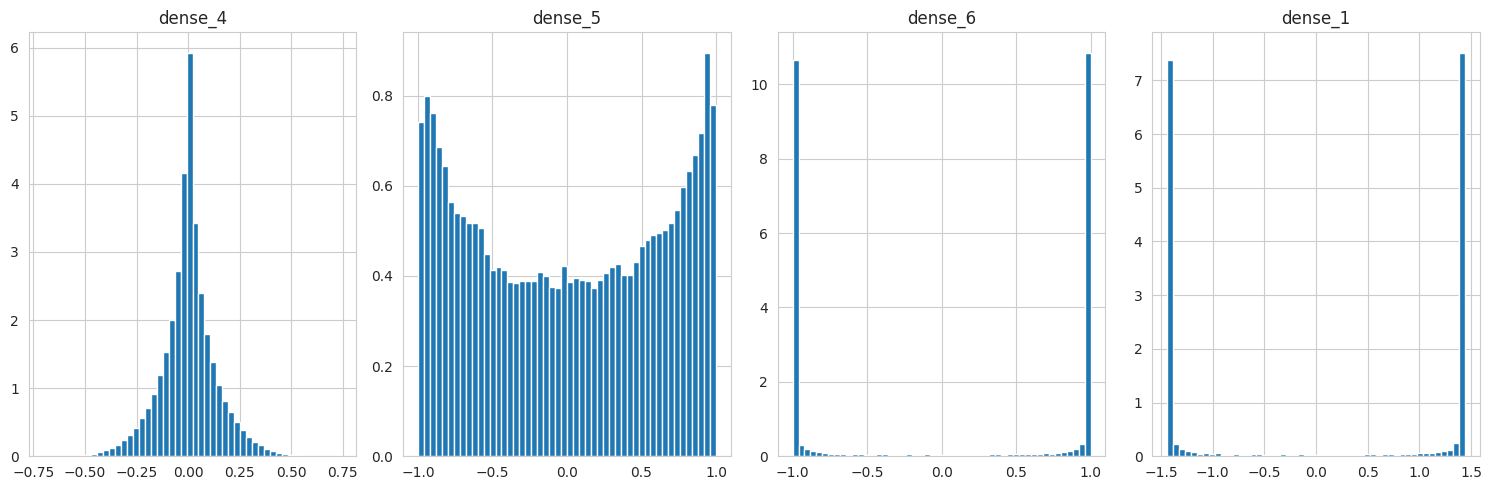

In [15]:
# Generate some random input data
x = np.random.randn(10000, 1)

# Get the activations for the input data
layer_outputs = []
layers = []
layer_names = []
for l in neat_model.layers:
    if l.name in ['dense_4', 'dense_5', 'dense_6', 'dense_1']:
        print(l.output)
        layer_outputs.append(l.output)
        layer_names.append(l.name)
        layers.append(l)
activation_model = tf.keras.models.Model(inputs=neat_model.inputs[1], outputs=layer_outputs)
activations = activation_model.predict(x)

# Plot the activations

# Determine the number of columns for the subplot
num_columns = len(layers)
# Create the subplot
fig, axs = plt.subplots(1, num_columns, figsize=(15, 5))
for ax, layer_name, activation in zip(axs, layer_names, activations):
    ax.set_title(layer_name)
    ax.hist(activation.flatten(), bins=50, density=True)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### plot weight distribution

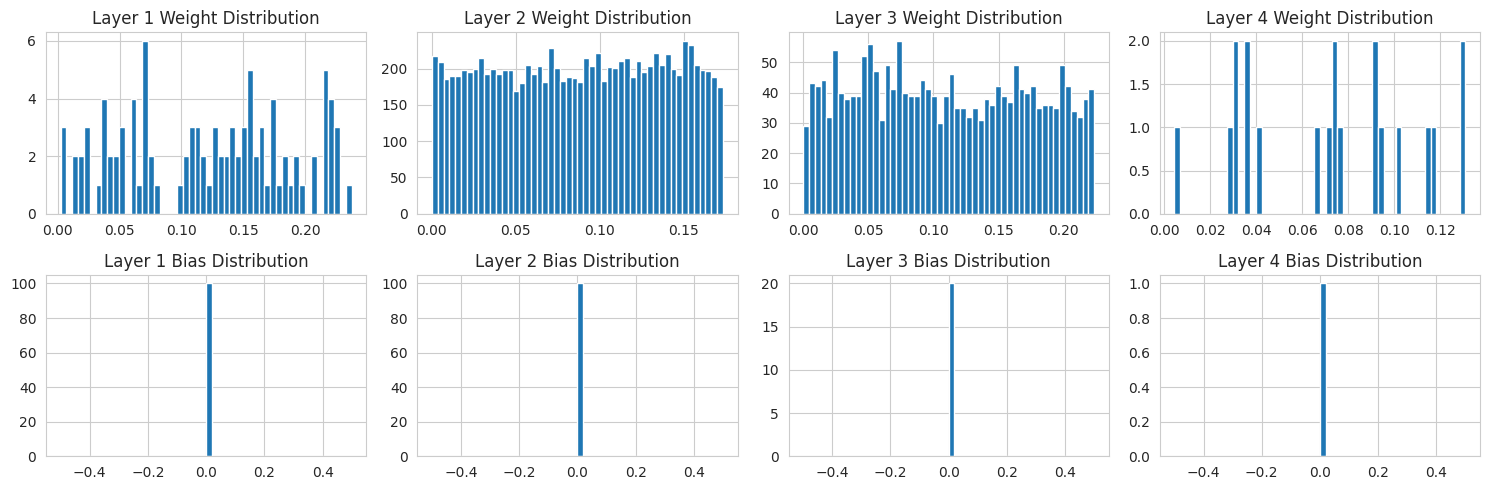

In [16]:
# Get the weights for each layer
layer_weights = [layer.get_weights() for layer in layers]

# Create the subplot
fig, axs = plt.subplots(2, num_columns, figsize=(15, 5))

# Plot the weight distribution for each layer
for i, weights in enumerate(layer_weights):
    axs[0,i].set_title(f"Layer {i+1} Weight Distribution")
    flattened_weights = weights[0].flatten()
    axs[0,i].hist(flattened_weights, bins=50)
    axs[1,i].set_title(f"Layer {i+1} Bias Distribution")
    flattened_weights = weights[1].flatten()
    axs[1,i].hist(flattened_weights, bins=50)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## adapted Xavier initialisation according equation
$ b=\sqrt{\frac{3}{n^{l-1}}} $

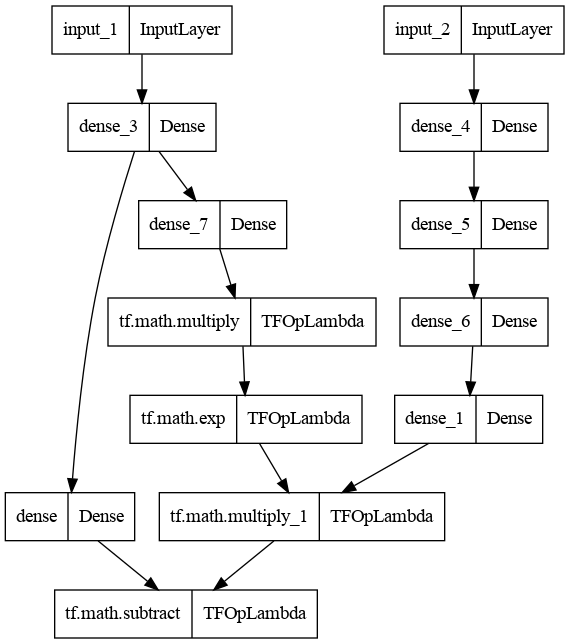

In [17]:
# recreate model
tf.keras.backend.clear_session()
def equation_xavier_init(shape, dtype=None):
    fan_in = shape[0]
    fan_out = shape[1]
    limit = np.sqrt(3. / (fan_in + fan_out))
    return tf.random.uniform(shape, minval=0., maxval=limit, dtype=dtype)
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=equation_xavier_init)
hp_param['net_y_size_trunk_args']['y_base_units'] = [100,100,20]
train_data, val_data, params = fit_func_prepare(hp_param, data_path)
neat_model = get_neat_model(dim_features=train_data[0].shape[1], **params)
tf.keras.utils.plot_model(neat_model)

### plot activation distribution

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_4/Tanh:0', description="created by layer 'dense_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_5/Tanh:0', description="created by layer 'dense_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='dense_6/Tanh:0', description="created by layer 'dense_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")
313/313 [==============================] - 1s 3ms/step


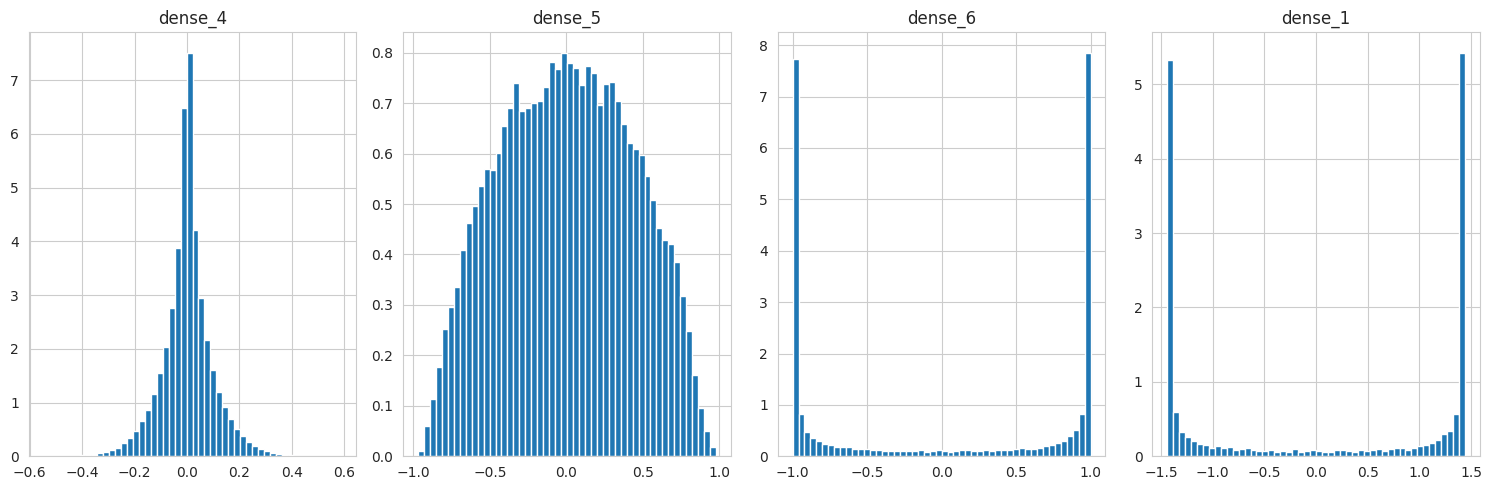

In [18]:
# Generate some random input data
x = np.random.randn(10000, 1)

# Get the activations for the input data
layer_outputs = []
layers = []
layer_names = []
for l in neat_model.layers:
    if l.name in ['dense_4', 'dense_5', 'dense_6', 'dense_1']:
        print(l.output)
        layer_outputs.append(l.output)
        layer_names.append(l.name)
        layers.append(l)
activation_model = tf.keras.models.Model(inputs=neat_model.inputs[1], outputs=layer_outputs)
activations = activation_model.predict(x)

# Plot the activations

# Determine the number of columns for the subplot
num_columns = len(layers)
# Create the subplot
fig, axs = plt.subplots(1, num_columns, figsize=(15, 5))
for ax, layer_name, activation in zip(axs, layer_names, activations):
    ax.set_title(layer_name)
    ax.hist(activation.flatten(), bins=50, density=True)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### plot weight distribution

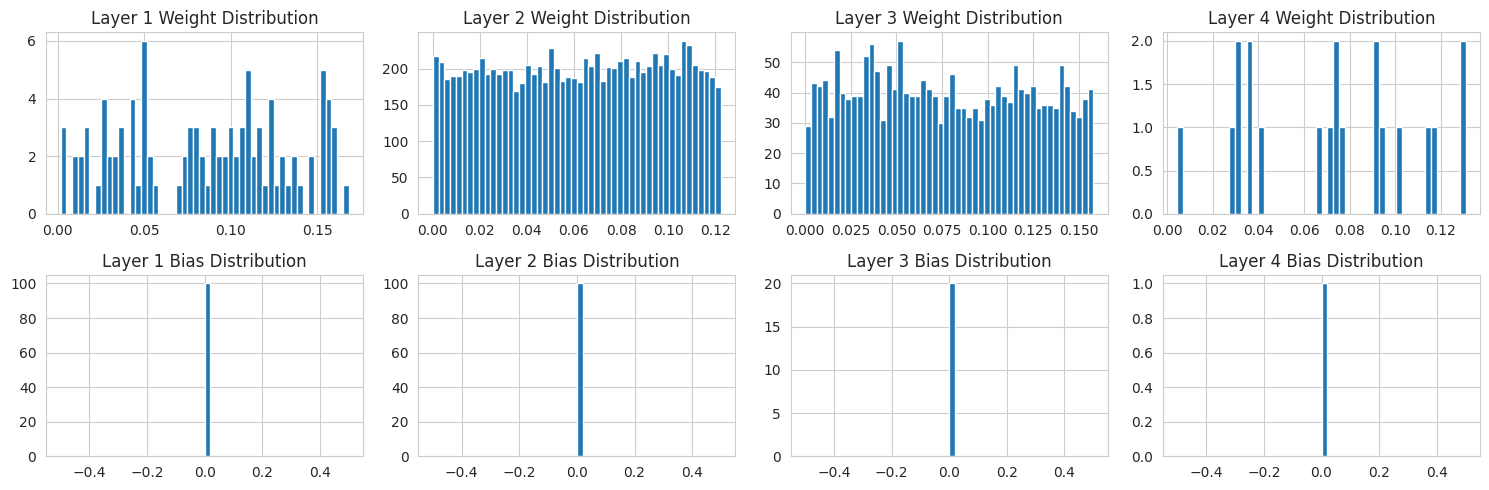

In [19]:
# Get the weights for each layer
layer_weights = [layer.get_weights() for layer in layers]

# Create the subplot
fig, axs = plt.subplots(2, num_columns, figsize=(15, 5))

# Plot the weight distribution for each layer
for i, weights in enumerate(layer_weights):
    axs[0,i].set_title(f"Layer {i+1} Weight Distribution")
    flattened_weights = weights[0].flatten()
    axs[0,i].hist(flattened_weights, bins=50)
    axs[1,i].set_title(f"Layer {i+1} Bias Distribution")
    flattened_weights = weights[1].flatten()
    axs[1,i].hist(flattened_weights, bins=50)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## plot weight and activation distribution of adapted xavier v2

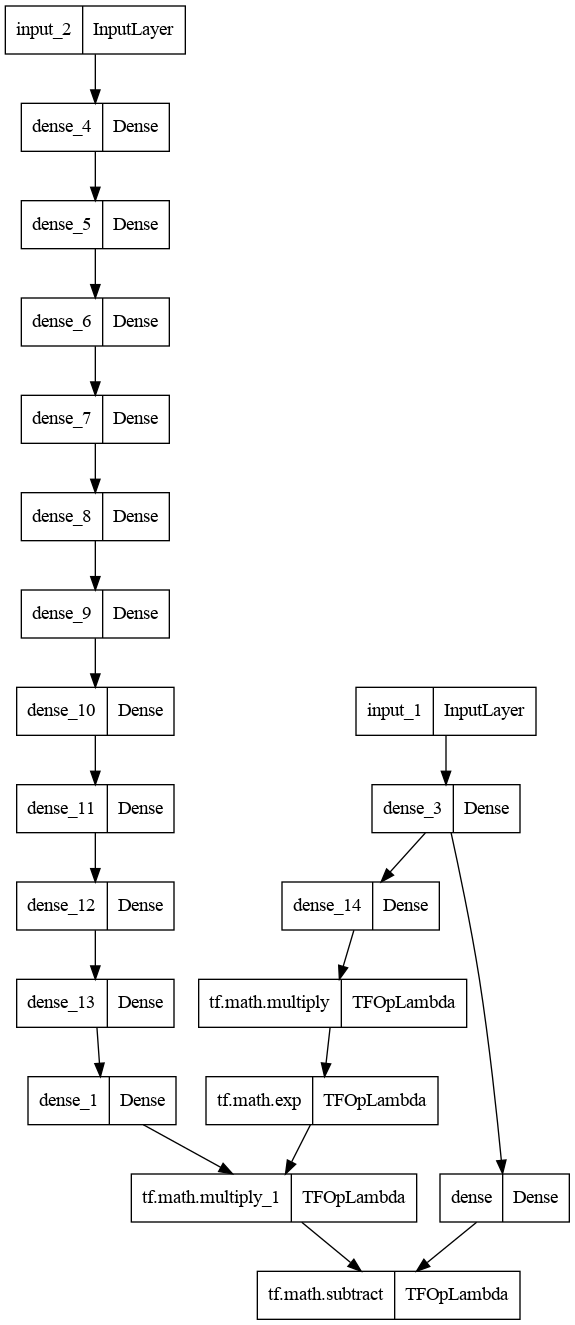

In [20]:
def constraint_xavier_p_init(shape, dtype=None):
    fan_in = shape[0]
    fan_out = shape[1]
    # limit = np.sqrt(6. / (fan_in+fan_out))
    limit = np.sqrt(9. / (np.max([fan_in, fan_out])**2))
    return tf.random.uniform(shape, minval=0, maxval=limit, dtype=dtype)

# recreate model
tf.keras.backend.clear_session()
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=constraint_xavier_p_init)
hp_param['net_y_size_trunk_args']['y_base_units'] = [10,20,50,100,200,500,200,100,50,10]
train_data, val_data, params = fit_func_prepare(hp_param, data_path)
neat_model = get_neat_model(dim_features=train_data[0].shape[1], **params)
tf.keras.utils.plot_model(neat_model)

### plot activation distribution

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_4/Tanh:0', description="created by layer 'dense_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='dense_5/Tanh:0', description="created by layer 'dense_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='dense_6/Tanh:0', description="created by layer 'dense_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_7/Tanh:0', description="created by layer 'dense_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200), dtype=tf.float32, name=None), name='dense_8/Tanh:0', description="created by layer 'dense_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 500), dtype=tf.float32, name=None), name='dense_9/Tanh:0', description="created

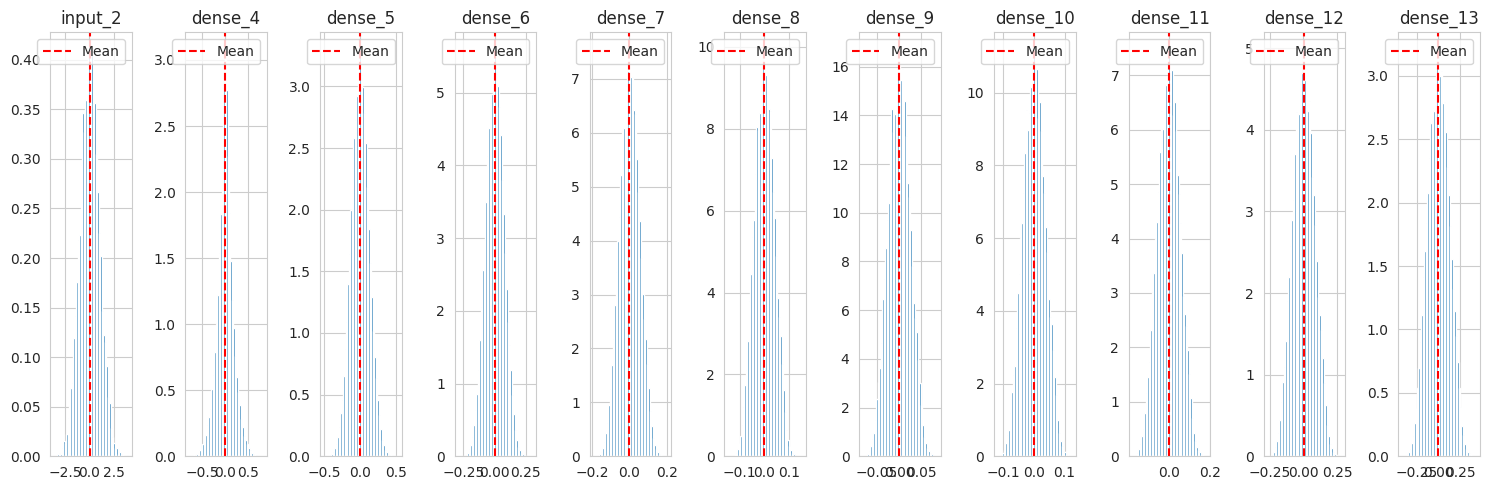

In [21]:
# Generate some random input data
x = np.random.randn(10000, 1)

# Get the activations for the input data
layer_outputs = []
layers = []
layer_names = []
for l in neat_model.layers:
    if l.name in ['input_2'] + [f"dense_{i}" for i in range(4,len(hp_param['net_y_size_trunk_args']['y_base_units'])+4)]:
        print(l.output)
        layer_outputs.append(l.output)
        layer_names.append(l.name)
        layers.append(l)
activation_model = tf.keras.models.Model(inputs=neat_model.inputs[1], outputs=layer_outputs)
activations = activation_model.predict(x)

# Plot the activations

# Determine the number of columns for the subplot
num_columns = len(layers)
# Create the subplot
fig, axs = plt.subplots(1, num_columns, figsize=(15, 5))
for ax, layer_name, activation in zip(axs, layer_names, activations):
    ax.set_title(layer_name)
    ax.hist(activation.flatten(), bins=50, density=True)
    ax.axvline(activation.flatten().mean(), color='red', linestyle='--', label='Mean')
    # ax.hist(a3.flatten(), bins=50, density=True, alpha=0.5)
    # ax.axvline(a3.flatten().mean(), color='orange', linestyle='--', label='Mean')
    ax.legend()
    print(f"{layer_name} activation std {activation.std()}")
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [22]:
# # Xavier without harmonic mean b=sqrt(12/fan_in)
# initial_weights = [l.get_weights() for l in layers]
# # Reinitialize the model parameters with new random values
# for layer, weights in zip(layers, initial_weights):
#     if "dense" in layer.name:
#         shape = weights[0].shape
#         fan_in = shape[0]
#         fan_out = shape[1]
#         limit = np.sqrt(6. / (fan_in))
#         limit = tf.convert_to_tensor(limit, dtype=weights[0].dtype)
#         weight_init = tf.random.uniform(weights[0].shape, minval=-limit, maxval=limit, dtype=weights[0].dtype)
#         bias_init = tf.zeros(weights[1].shape)
#         layer.set_weights([weight_init, bias_init])

In [23]:
# # Xavier with normal
# initial_weights = [l.get_weights() for l in layers]
#
# # Reinitialize the model parameters with new random values
# for layer, weights in zip(layers, initial_weights):
#     if "dense" in layer.name:
#         shape = weights[0].shape
#         fan_in = shape[0]
#         fan_out = shape[1]
#         limit = np.sqrt(2. / (fan_in + fan_out))
#         limit = tf.convert_to_tensor(limit, dtype=weights[0].dtype)
#         weight_init = tf.random.normal(weights[0].shape, mean=0, stddev=limit, dtype=weights[0].dtype)
#         bias_init = tf.zeros(weights[1].shape)
#         layer.set_weights([weight_init, bias_init])

In [24]:
# # Xavier with normal
# initial_weights = [l.get_weights() for l in layers]
#
# # Reinitialize the model parameters with new random values
# for layer, weights in zip(layers, initial_weights):
#     if "dense" in layer.name:
#         shape = weights[0].shape
#         fan_in = shape[0]
#         fan_out = shape[1]
#         limit = np.sqrt((2. / (fan_in + fan_out)))
#         limit = tf.convert_to_tensor(limit, dtype=weights[0].dtype)
#         weight_init = tf.random.normal(weights[0].shape, mean=0., stddev=limit, dtype=weights[0].dtype)
#         bias_init = tf.zeros(weights[1].shape)
#         layer.set_weights([weight_init, bias_init])

In [25]:
# # Get the initial weights for each layer
# initial_weights = [layer.get_weights() for layer in layers]
#
# # Reinitialize the model parameters with new random values
# for layer, weights in zip(layers, initial_weights):
#     if "dense" in layer.name:
#         shape = weights[0].shape
#         fan_in = shape[0]
#         fan_out = shape[1]
#         # limit = np.sqrt(3. / (fan_in + fan_out))
#         # limit = np.sqrt(12. / (4*fan_in + fan_out))
#         # limit = np.sqrt(12. / (fan_in + 4.*fan_out))
#         limit = np.sqrt(6. / (fan_in**2 + fan_out))
#         print(limit)
#         weight_init = tf.random.uniform(weights[0].shape, minval=0., maxval=limit, dtype=weights[0].dtype)
#         bias_init = tf.zeros(weights[1].shape)
#         layer.set_weights([weight_init, bias_init])

### plot weight distribution

Mean: 0.3445473909378052
Std: 0.07165259
Mean: 0.1513511687517166
Std: 0.042657983
Mean: 0.05823507905006409
Std: 0.017322563
Mean: 0.029515312984585762
Std: 0.008744096
Mean: 0.015074926428496838
Std: 0.004325194
Mean: 0.005992148537188768
Std: 0.0017343576
Mean: 0.005995869170874357
Std: 0.0017318259
Mean: 0.014973129145801067
Std: 0.0043671103
Mean: 0.029869500547647476
Std: 0.008702985
Mean: 0.06236041337251663
Std: 0.01751349


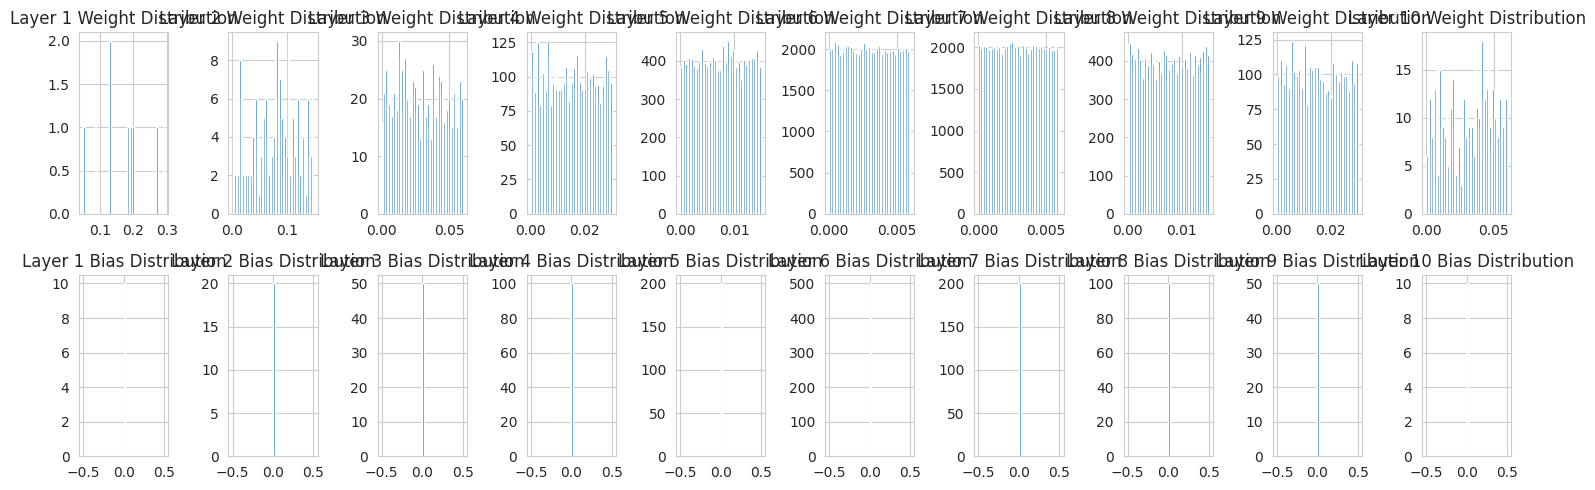

In [26]:
# Get the weights for each layer
layer_weights = [layer.get_weights() for layer in layers[1:]]

# Create the subplot
fig, axs = plt.subplots(2, num_columns-1, figsize=(15, 5))

# Plot the weight distribution for each layer
for i, weights in enumerate(layer_weights):
    axs[0,i].set_title(f"Layer {i+1} Weight Distribution")
    flattened_weights = weights[0].flatten()
    print("Mean:" ,flattened_weights.mean()*2)
    print("Std:" ,flattened_weights.std())
    axs[0,i].hist(flattened_weights, bins=50)
    axs[1,i].set_title(f"Layer {i+1} Bias Distribution")
    flattened_weights = weights[1].flatten()
    axs[1,i].hist(flattened_weights, bins=50)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()